In [60]:
%matplotlib notebook
import math
import os
import pandas as pd 
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt 
import warnings

warnings.filterwarnings("ignore")

In [61]:
data=pd.read_csv("data/AirPassengers.csv",index_col="Month")
print(data.shape)
data.head()

(144, 1)


,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


<IPython.core.display.Javascript object>


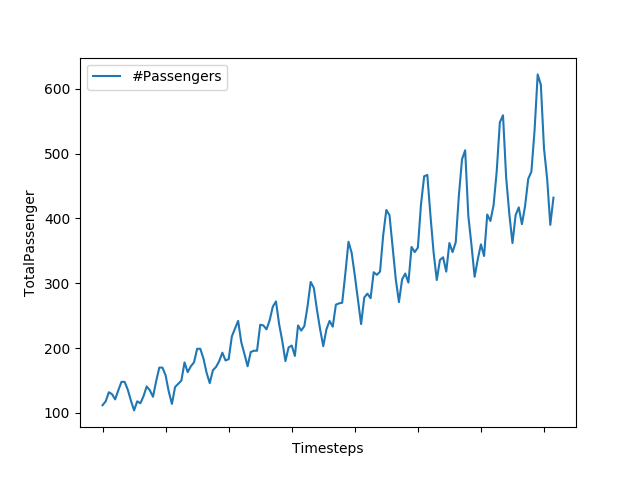

In [63]:
data.plot()
plt.xlabel("Timesteps")
plt.ylabel("TotalPassenger")
plt.show()

In [4]:
train=data[:100]
test=data[100:]

In [64]:
scaler=preprocessing.MinMaxScaler()
train=scaler.fit_transform(train)
test=scaler.transform(train)


In [65]:
def make_data(train,test,time_steps=20):
    x_train=[]
    y_train=[]
    for i in range(time_steps,100):
        x_train.append(train[i-time_steps:i,0])
        y_train.append(train[i])
    x_train,y_train=np.array(x_train),np.array(y_train)

    x_test=[]
    y_test=[]
    
    for i in range(time_steps,44):
        x_test.append(test[i-time_steps:i,0])
        y_test.append(test[i])

    x_test,y_test=np.array(x_test),np.array(y_test)
    
    return x_train,y_train,x_test,y_test

# Dynamic RNN

In [83]:
from tensorflow.contrib.layers import fully_connected

In [84]:
tf.reset_default_graph()

# get data
x_train,y_train,x_test,y_test=make_data(train,test,20)

n_steps=20
n_inputs=1
n_neurons=10
n_outputs=1

learning_rate=0.001

x=tf.placeholder(tf.float32,[None,n_steps,n_inputs])
y=tf.placeholder(tf.float32,[None,1])

In [85]:
basic_cell=tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,activation=tf.nn.selu)
outputs,states=tf.nn.dynamic_rnn(basic_cell,x,dtype=tf.float32)

In [86]:
pred=fully_connected(states, n_outputs, activation_fn=None)
loss=tf.losses.mean_squared_error(y,pred)

In [87]:
optimizer=tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

In [88]:
def plot_dynamic(y_train,prediction,ax,e,l,clear=True):
    if clear :
        ax.clear()
    ax.set_title("Epoch :{} | Loss :{:2.3f}".format(e,l))
    ax.plot(y_train,color="b",label="train")
    ax.plot(prediction,color="r",label="prediction")
    ax.legend()
    fig.canvas.draw()
    

<IPython.core.display.Javascript object>


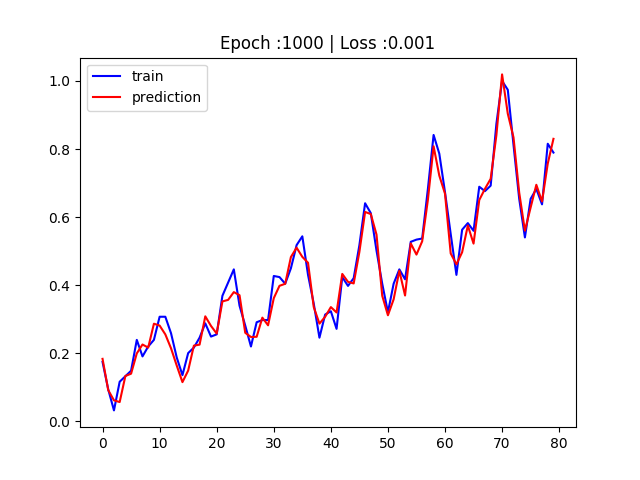

In [89]:
epochs=1000

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    fig,ax = plt.subplots(1,1)
    for epoch in range(epochs+1):
        feed_dict={x:x_train.reshape(x_train.shape[0],n_steps,1),y:y_train}
        sess.run(optimizer,feed_dict=feed_dict)
        if epoch%100==0:
            l=sess.run(loss,feed_dict=feed_dict)
            #print(l)
            prediction=sess.run(pred,feed_dict=feed_dict)
            
            plot_dynamic(y_train,prediction,ax,epoch,l)
            plt.show()
    #fig.canvas.close_event(ax)
    prediction_test=sess.run(pred,feed_dict={x:x_test.reshape(x_test.shape[0],x_test.shape[1],1),y:y_test}) 

<IPython.core.display.Javascript object>


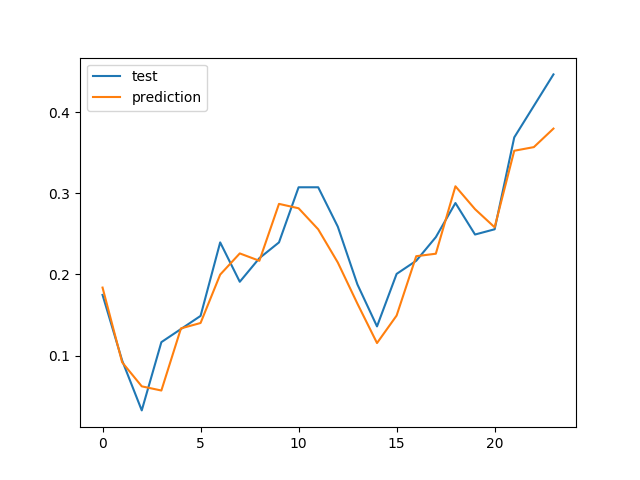

In [90]:
plt.figure()
plt.plot(y_test,label="test")
plt.plot(prediction_test,label="prediction")
plt.legend()
plt.show()

# Static RNN

In [91]:
tf.reset_default_graph()

In [92]:
n_x=1
n_y=1

state_size = 15
n_epochs = 100
n_timesteps = 20   # number of time steps
n_x_vars = 1  # number of x variables
n_y_vars = 1  # number of y variables
learning_rate = 0.1

In [93]:
x_p=tf.placeholder(tf.float32,[None,n_timesteps,n_x_vars],name="x_p")
# (batch_size, n_steps, n_input)
# n_steps tensors list of shape (batch_size, n_input)
y_p = tf.placeholder(tf.float32, [None, n_y_vars], name='Y_p')

# make a list of tensors of length n_x
rnn_inputs = tf.unstack(x_p,axis=1)

In [94]:
cell = tf.nn.rnn_cell.BasicRNNCell(state_size,activation=tf.nn.relu)

In [95]:
rnn_outputs, final_state = tf.nn.static_rnn(cell, 
                                            rnn_inputs,
                                            dtype=tf.float32)

In [96]:
out_rnn=rnn_outputs[-1]
w=tf.get_variable("w",[state_size,1])
b=tf.get_variable("b",[n_y_vars],initializer=tf.constant_initializer(0.0))
pred=tf.matmul(out_rnn,w)+b
#preds = [tf.matmul(rnn_output, w) + b for rnn_output in rnn_outputs]

In [97]:
loss=tf.losses.mean_squared_error(y_p,pred)
optimizer=tf.train.RMSPropOptimizer(learning_rate=0.01).minimize(loss)

In [98]:
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)
epochs=10000
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    epoch_loss=0.0
    
    for epoch in range(epochs):
        feed_dict={x_p:x_train,y_p:y_train}
        l,_=sess.run([loss,optimizer],feed_dict=feed_dict)
        if epoch%1000==0:
            print(l)
    prediction=sess.run(pred,feed_dict={x_p:x_test,y_p:y_test})

0.41997862
0.0020172633
0.0005722946
0.000261472
0.0019782004
0.002575751
0.0006769042
0.0022935413
0.005192532
0.0030846042


<IPython.core.display.Javascript object>


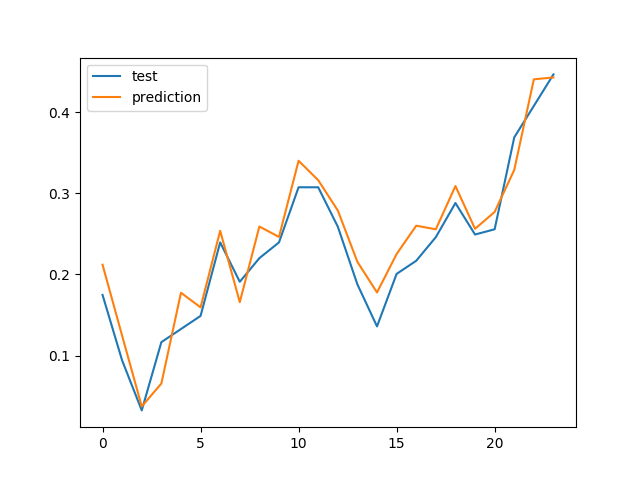

In [99]:
plt.figure()
plt.plot(y_test,label="test")
plt.plot(prediction,label="prediction")
plt.legend()
plt.show()